In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [14]:
%pip install lifelines

In [15]:
df = pd.read_csv('/content/Breast Cancer METABRIC (2).csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   float64
 12  HER2 status measured by SNP6    19

In [17]:
wanted_cols = ['Age at Diagnosis', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
               'Pam50 + Claudin-low subtype', 'ER Status', 'Neoplasm Histologic Grade',
               'HER2 Status', 'Hormone Therapy', 'Inferred Menopausal State',
               'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index',
               'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy',
               'Relapse Free Status (Months)', 'Relapse Free Status', 'Tumor Size', 'Tumor Stage']

In [18]:
df = data[wanted_cols].dropna()
df['event'] = np.where(df['Overall Survival Status'].str.lower().str.contains('deceased|died'), 1, 0)
df['time'] = df['Overall Survival (Months)']

In [19]:
cat_cols = ['Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype',
            'ER Status', 'Neoplasm Histologic Grade', 'HER2 Status', 'Hormone Therapy',
            'Inferred Menopausal State', 'PR Status', 'Radio Therapy', 'Relapse Free Status']

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

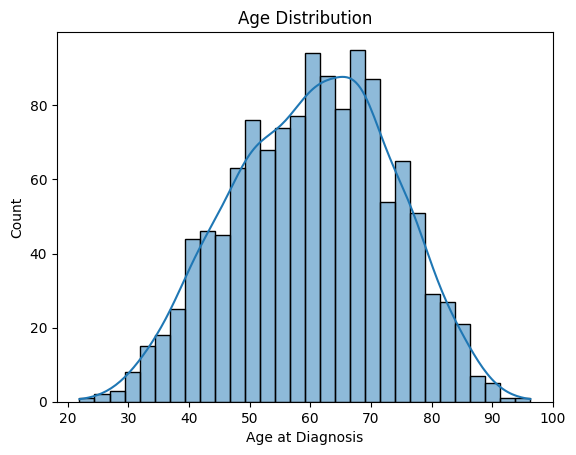

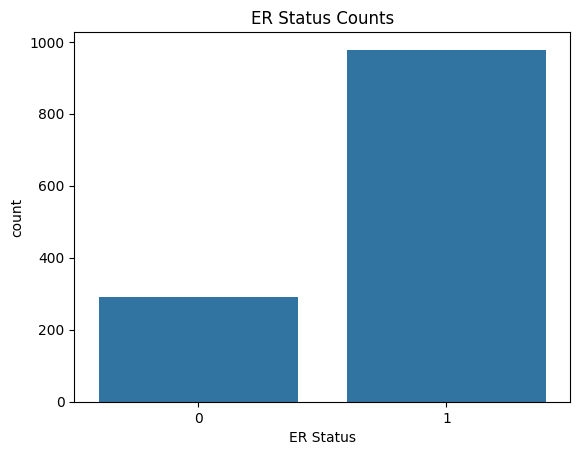

In [20]:
sns.histplot(df['Age at Diagnosis'], bins=30, kde=True); plt.title('Age Distribution'); plt.show()
sns.countplot(x='ER Status', data=df); plt.title('ER Status Counts'); plt.show()

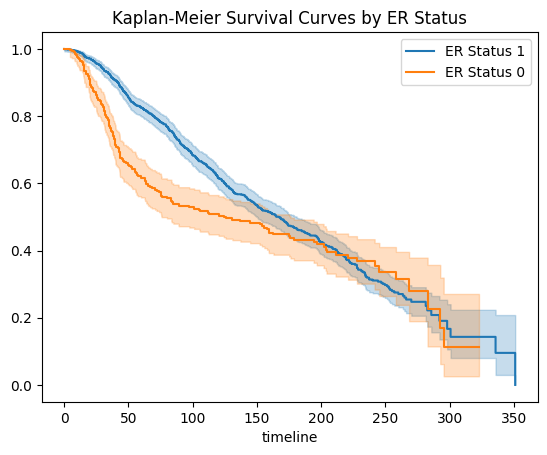

In [21]:
kmf = KaplanMeierFitter()
plt.figure()
for group in df['ER Status'].unique():
    ix = df['ER Status'] == group
    kmf.fit(df['time'][ix], event_observed=df['event'][ix], label=f'ER Status {group}')
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves by ER Status')
plt.show()

In [22]:
cph_df = df[['time', 'event', 'Age at Diagnosis', 'ER Status', 'HER2 Status', 'Tumor Stage', 'Lymph nodes examined positive']]
cph = CoxPHFitter()
cph.fit(cph_df, 'time', 'event')
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1269 total observations, 548 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1269
number of events observed = 721
   partial log-likelihood = -4526.06
         time fit was run = 2025-10-17 07:32:24 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Age at Diagnosis               0.04      1.04      0.00            0.03            0.04                1.03                1.04
ER Status                     -0.31      0.74      0.09           -0.49           -0.12                0.61                0.89
HER2 Status                    0.38      1.46      0.12            0.15            0.61                1.17                1.84
Tumor Stage                    0.32      1.38      0.07            0.19            0.45                1.21                1.57
Lymph nodes examined positive  0.06      1.06      0.01            0.04            0.08                1.04                1.08

                               cmp to     z      p  -log2(p)
covariate                                                   
Age at Diagnosis                 0.00 10.86 <0.005     88.81
ER Status                        0.00 -3.26 <0.005      9.80
HER2 Status                      0.00  3.27 <0.005      9.88
Tumor Stage                      0.00  4.81 <0.005     19.33
Lymph nodes examined positive    0.00  6.24 <0.005     31.11
---
Concordance = 0.67
Partial AIC = 9062.12
log-likelihood ratio test = 257.79 on 5 df
-log2(p) of ll-ratio test = 175.83

In [23]:
df['mortality_10yr'] = np.where((df['event'] == 1) & (df['time'] <= 120), 1, 0)

In [24]:
X = df.drop(['time', 'event', 'Overall Survival (Months)', 'Overall Survival Status', 'mortality_10yr'], axis=1)
y = df['mortality_10yr']
X = StandardScaler().fit_transform(X)

In [25]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier()
}

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}, ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

Logistic Regression Accuracy: 0.86, ROC-AUC: 0.94
SVM Accuracy: 0.87, ROC-AUC: 0.93
Decision Tree Accuracy: 0.85, ROC-AUC: 0.84


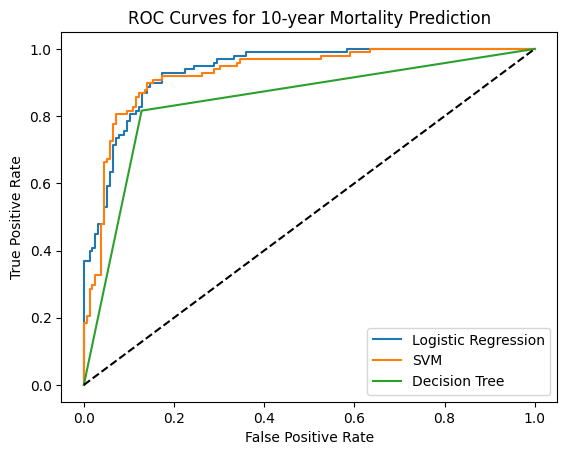

In [28]:
plt.figure()
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for 10-year Mortality Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()